# Data Preparation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
import random
import re
from gensim.utils import tokenize
from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/raw-data/lyrics_data.csv')
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [4]:
df_art = pd.read_csv('../data/raw-data/artists_data.csv')
df_art.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [5]:
# Get only lyrics in English
df = df[df['language']=='en'].reset_index(drop=True)

## Genre

In [6]:
genres = []
for artist_id in df['ALink']:
    # Get the row corresponding to the artist
    artist_row = df_art[df_art['Link']==artist_id].reset_index()
    try:
        # Get all genres from that artist
        genres_in_artist = artist_row['Genres'][0].split('; ')        
    except:
        genres_in_artist = []
    genres.append(genres_in_artist)

In [7]:
df = df.drop(columns = ['ALink', 'SName', 'SLink', 'language'])
df = df.rename(columns={'Lyric': 'lyrics'})

In [8]:
genres = pd.Series(genres)
mlb = MultiLabelBinarizer()
# Do one hot encoding
genres_one_hot = pd.DataFrame(
    mlb.fit_transform(genres), 
    columns=mlb.classes_,
    index=genres.index)
genres_one_hot.head()

,Axé,Black Music,Blues,Bossa Nova,COLETÂNEA,Chillout,Classic Rock,Clássico,Country,Dance,...,Soul Music,Surf Music,Tecnopop,Trance,Trap,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
genres_one_hot.sum().sort_values(ascending=False)[:10]

Rock           63717
Pop            33571
Pop/Rock       26360
Heavy Metal    21759
Hip Hop        20902
Indie          20134
Romântico      17947
Hard Rock      17250
Rap            17114
R&B            15581
dtype: int64

In [10]:
# Keep only the 8 most frequent genres (some of them will also be merged)
genres2keep = genres_one_hot.sum().sort_values(ascending=False)[:9].keys()

format_label = lambda s: s.lower().replace(' ', '-').replace('/', '-')

genres_one_hot = genres_one_hot[genres2keep]
format_mapping = dict([(
    genre_label, format_label(genre_label)) for genre_label in genres_one_hot.keys()])

genres_one_hot = genres_one_hot.rename(columns = format_mapping)

In [11]:
df = pd.concat([df, genres_one_hot], axis=1)

In [12]:
genre_labels = [label for label in df.keys() if label != 'lyrics']

# Remove lyrics that do not fit into the main genres
df = df.drop(df[df[genre_labels].sum(axis=1) == 0].index)

In [13]:
jaccard_similarity = lambda x, y: np.logical_and(x, y).sum() / np.logical_or(x, y).sum()

genre_pairs = list(combinations(genre_labels, 2))

genre_similarities = [jaccard_similarity(df[genre_pair[0]], df[genre_pair[1]]) 
    for genre_pair in genre_pairs]

sorted(list(zip(genre_pairs, genre_similarities)),
    reverse=True, key=lambda x: x[1])[:20]

[(('hip-hop', 'rap'), 0.5317297231959386),
 (('heavy-metal', 'hard-rock'), 0.29537756525204223),
 (('rock', 'hard-rock'), 0.2094735898661568),
 (('pop', 'pop-rock'), 0.20258854218922445),
 (('rock', 'heavy-metal'), 0.15670672296200064),
 (('pop', 'romântico'), 0.13970311704975333),
 (('rock', 'pop-rock'), 0.13782431852057703),
 (('pop-rock', 'romântico'), 0.10936678434612784),
 (('rock', 'indie'), 0.10295433021151215),
 (('pop', 'hip-hop'), 0.058550330353672755),
 (('rock', 'romântico'), 0.0391540585593037),
 (('pop-rock', 'indie'), 0.03575486199291586),
 (('pop', 'rap'), 0.03301742586365026),
 (('pop', 'indie'), 0.02956118321415563),
 (('rock', 'pop'), 0.029502645502645503),
 (('indie', 'romântico'), 0.029299672946455118),
 (('pop-rock', 'hard-rock'), 0.012772875058058523),
 (('rock', 'hip-hop'), 0.007644950403086559),
 (('indie', 'hard-rock'), 0.007030681787571048),
 (('romântico', 'hard-rock'), 0.005513655582219175)]

In [14]:
# Merge together rap and hip hop
df['rap'] = np.logical_or(df['rap'], df['hip-hop']).replace({True: 1, False: 0})
# Drop columns
df = df.drop(columns=['romântico'])
df = df.drop(columns=['hip-hop'])
# Remove again lyrics that do not fit into the genres kept
genre_labels = [label for label in df.keys() if label != 'lyrics']
df = df.drop(df[df[genre_labels].sum(axis=1) == 0].index)

In [15]:
df = df.reset_index(drop=True)
print(f'Number of lyrics: {len(df)}')

Number of lyrics: 143165


## Text Cleaning

In [16]:
# Duplicates are songs with multiple artists (e.g. a featuring)
# Remove duplicates having the same genre
print(f'Duplicates with the same genre: {df.duplicated().sum()}')
df = df.drop_duplicates()
# Remove lyrics with different genres among duplicates:
print(f'Duplicates with different genres: {df.duplicated(subset="lyrics").sum()}')
df = df.drop_duplicates(subset="lyrics", keep=False)

Duplicates with the same genre: 646


Duplicates with different genres: 555


In [17]:
rand = random.choice(df['lyrics'])
rand

"Be my woman, girl\nI'll be your man\nBe my woman, girl\nI'll be your man\n\nYes I'll be your woman\nYes I'll be your baby\nYes I'll be whatever, that you tell me when you're ready\nYes I'll be your girl, forever your lady\nYou ain't never gotta worry, I'm down for you baby\n\nBest believe that, when you need that\nI'll provide that, you will always have it\nI'll be on deck, keep it in check\nWhen you need that, I'ma let you have it\n\nBeating my drum like, dum di di dey\nI like the dirty rhythm you play\nI wanna hear you calling my name\nLike, hey mama, mama, hey mama, ma\nBanging the drum like, dum di di dey\nI know you want it in the worst way\nI wanna hear you calling my name\nLike, hey mama, mama, hey mama, ma\n\nBe my woman, girl\nI'll be your man\nBe my woman, girl\nI'll be your man\n\nYes I'll do the cooking\nYes I'll do the cleaning\nPlus I keep the na-na real sweet for your eating\nYes you be the boss, yes I be respecting\nWhatever that you tell me cause it's game you be spit

In [18]:
def clean_text(lyrics):
    lyrics = re.sub(r'\((.+?)?\)', '', lyrics)
    lyrics = re.sub(r'\[(.+?)?\]', '', lyrics)
    lyrics = re.sub(r'\{(.+?)?\}', '', lyrics)
    lyrics = re.sub(r'\n+', '\n', lyrics)
    lyrics = re.sub(r'^[^a-zA-Z]+$', '', lyrics, flags=re.MULTILINE)
    return lyrics

In [19]:
rand = random.choice(df['lyrics'])
clean_text(rand)

'I tried to hang on for as long as I could\nBut now I can see that it just ainâ€™t no good\nOur love it has wasted\nRight down to the core\nWhatever we had\nWe donâ€™t have anymore\nYouâ€™ve got to get off a road to nowhere\nYouâ€™ve got to get off a road to nowhere\nWell I tried and I tried to make things work out right\nBut I guess weâ€™re two people who canâ€™t help but fight\nYour eyes they are open\nAnd oh so are mine\nWe both need our freedom\nDonâ€™t you think itâ€™s about time\nIâ€™m trying to get off this road to nowhere\nIâ€™m trying to get off this road to nowhere\nThank you for the good times weâ€™ve had in the past\nBut we both know enough to know good times donâ€™t last\nBaby youâ€™re just no good for me\nAnd Iâ€™m no good for you\nLetâ€™s not waste our time talkinâ€™\nWe both know what to do\nWeâ€™ve got to get off this road to nowhere\nItâ€™s time to get off this road to nowhere\nYouâ€™ve got to get off this road to nowhere\nWeâ€™ve got to get off this road to nowhere\n

In [20]:
df['lyrics'] = [clean_text(lyrics) for lyrics in df['lyrics']]

In [21]:
# Split lyrics in verses consider \n as sep, filter empty element in list (it's the result of '\n\n' or spaces)
df['lyrics'] = list(map(lambda x: [verse for verse in x.split('\n') if verse.strip()], df['lyrics']))

In [22]:
# Count number of verses
df['verses'] = df['lyrics'].apply(len)

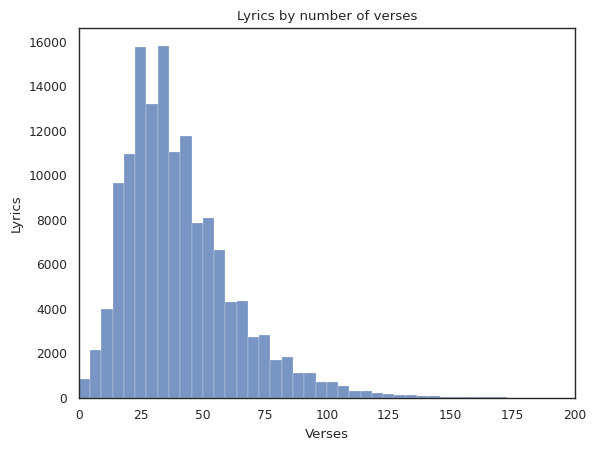

In [23]:
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=200)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
ax.set_xlim([0, 200])
tikzplotlib.save('../tikz/hist_lyrics_verses.tex')

In [24]:
df = df[df['verses']>20]

In [25]:
print(f'Number of lyrics: {len(df)}')

Number of lyrics: 119441


## Genre Label Filtering

In [26]:
# Get unique labels and compute value counts
df[df[genre_labels].sum(axis=1) == 1][genre_labels].sum(axis=0)

rock           19928
pop            15989
pop-rock        5151
heavy-metal     6201
indie           6737
hard-rock       1186
rap            19053
dtype: int64

In [27]:
# Drop songs with multiple genres
df = df.drop(df[df[genre_labels].sum(axis=1) > 1].index)
# Keep only rock, pop and rap lyrics:
# 1) Remove columns
df = df.drop(columns=['pop-rock','heavy-metal','indie','hard-rock'])
# 2) Remove rows
genre_labels = ['rock','pop','rap']
df = df.drop(df[df[genre_labels].sum(axis=1) == 0].index)

In [28]:
# Map again dummy variables to labels
df['genre'] = df[['rock', 'pop', 'rap']].apply(
    lambda x: 'rock' if x[0] == 1 else ('pop' if x[1] == 1 else ('rap' if x[2] == 1 else None)), axis=1)

# Drop dummy variables
df = df.drop(columns=['rock', 'pop', 'rap'])

df['genre'].value_counts()

rock    19928
rap     19053
pop     15989
Name: genre, dtype: int64

## Outlier Detection

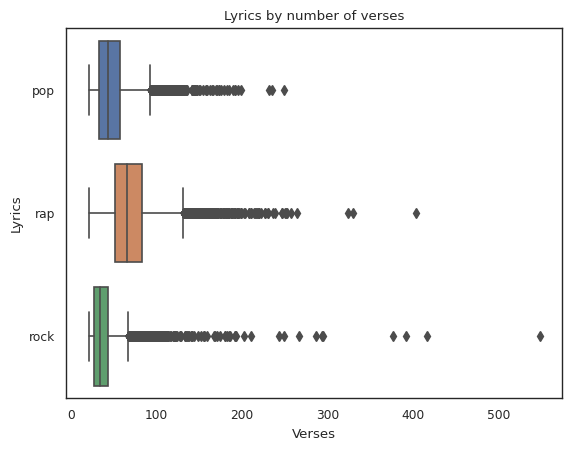

In [29]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x='verses', y='genre')
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
tikzplotlib.save('../tikz/box_lyrics_verses.tex')

In [30]:
# Drop the outlier rows from the DataFrame
df = df.drop(df[df['verses'] > 300].index)

In [31]:
lyrics_by_verse = zip(list(df['lyrics']),list(df['genre']),list(df.index))

verses_by_genre = [(verse, genre, index) for lyrics, genre, index in lyrics_by_verse for verse in lyrics]

df_verses = pd.DataFrame(verses_by_genre, columns=['verse','genre','index'])

df_verses.head()

,verse,genre,index
0,I feel so unsure,pop,0
1,As I take your hand and lead you to the dance ...,pop,0
2,"As the music dies, something in your eyes",pop,0
3,Calls to mind a silver screen,pop,0
4,And all those sad goodbyes,pop,0


In [32]:
df_verses['tokens'] = [len(list(tokenize(verse))) for verse in df_verses['verse']]

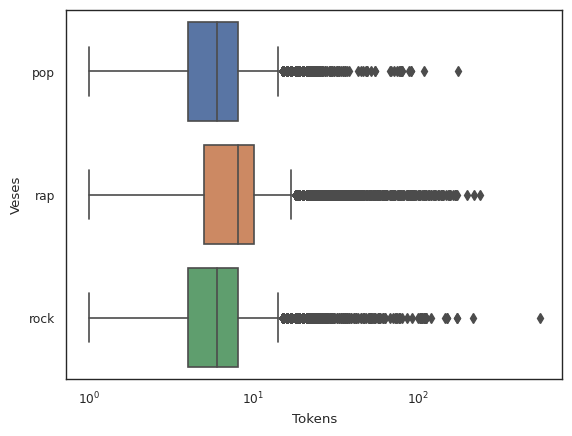

In [33]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df_verses, x='tokens', y='genre')
ax.set_xlabel('Tokens')
ax.set_ylabel('Veses')
ax.set_xscale('log')
tikzplotlib.save('../tikz/box_verses_tokens.tex')

In [34]:
df['lyrics'][df_verses[(df_verses['genre']=='rock') & (df_verses['tokens']>500)]['index']].values

array([list(['I wait for my true love, but she never came', 'I cry for my true love, but she never came', 'I leave this world never knowing who she was, departing all alone..', "I'd just like to speak for a second and say that, hum.. I just encourage everybody who hears this album to look towards Christ and not towards people, because people allow you to fall away, people aren't perfect. Theres only one person thats perfect and thats Christ. And I see people every day who are looking at Christ and blow Christ off because something that someone else has failed on. And its just not worth it, Christ has blessed me and every other member of this band more than any other way that I can imagine, or be spoken. Just the way everything worked out tonight was just beautiful. I just pray for each and every one of you, we wouldn't sit here and we wouldn't do this unless we wouldn't put the time into it unless it was trying to touch you, trying to reach your life and I just ask please just give you

In [35]:
# Compute the IQR for each genre
grouped = df_verses.groupby('genre')
# Compute IQR for each group
iqr = grouped.apply(lambda x: x['tokens'].quantile(0.75) - x['tokens'].quantile(0.25))
# Compute upper bounds for each group
upper_bound = grouped.apply(lambda x: x['tokens'].quantile(0.75) + 3 * iqr[x.name])
# Reset the index of the upper_bound series to match the labels of the grouped DataFrame
upper_bound = upper_bound
# Mark outliers
df_verses['outlier'] = np.where(df_verses['tokens'] > upper_bound[df_verses['genre']].values, True, False)
# Get the index values of the outlier rows
outlier_index = df_verses[df_verses['outlier'] == True]['index'].unique()

In [36]:
upper_bound

genre
pop     20.0
rap     25.0
rock    20.0
dtype: float64

In [37]:
len(outlier_index)

613

In [38]:
# Drop the outlier rows from the DataFrame
df = df.drop(outlier_index)

In [39]:
df['genre'].value_counts()

rock    19748
rap     18719
pop     15883
Name: genre, dtype: int64

In [40]:
print(f'Number of lyrics {len(df)}')

Number of lyrics 54350


In [41]:
df = df.reset_index(drop=True)
# Keep original index as id incase we want to retrieve samples in original df
df['id'] = df.index

In [42]:
df.drop(columns=['verses']).to_csv('../data/lyrics.csv', index=False)

## Classification and Evaluation Datasets

In [43]:
df_eval = df.groupby("genre").sample(n=50, weights='verses',random_state=42
).reset_index( 
).drop(columns=['verses'])

df_eval.to_csv('../data/evaluation/lyrics_eval.csv', index=False)

In [44]:
df = df.drop(columns=['verses'])

In [45]:
y = list(df['genre'])
X = list(zip(list(df['lyrics']),list(df['id'])))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
df_train = pd.DataFrame(X_train, columns=['lyrics','id'])
df_train['genre'] = y_train
df_train.shape

(43480, 3)

In [47]:
df_test = pd.DataFrame(X_test, columns=['lyrics','id'])
df_test['genre'] = y_test
df_test.shape

(10870, 3)

In [48]:
df_train.to_csv('../data/classification/lyrics_train.csv', index=False)
df_test.to_csv('../data/classification/lyrics_test.csv', index=False)

## Evaluation Dataset Preparation

In [49]:
import pandas as pd
import numpy as np
import random
import ast
import nlpaug.augmenter.word as naw
from math import sqrt
from sklearn.model_selection import train_test_split

2023-02-12 16:54:30.932226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-02-12 16:54:32.796384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-12 16:54:32.796583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-12 16:54:32.796592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [50]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [51]:
df.head()

,index,lyrics,genre,id
0,14308,"[""Make yaself, Don't break yaself"", ""Make yase...",pop,14308
1,36771,"['You will always be my baby', ""There's a thou...",pop,36771
2,33221,"['Hard to find a way to get through', ""It's a ...",pop,33221
3,31036,"[""We're boarding the night train"", ""We're bore...",pop,31036
4,10925,"['Come come baby', 'I can see you wanna touch ...",pop,10925


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   150 non-null    int64 
 1   lyrics  150 non-null    object
 2   genre   150 non-null    object
 3   id      150 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ KB


In [53]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))

In [54]:
eg_lyrics = random.choice(df['lyrics'])

In [55]:
aug = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")

In [56]:
def misalign_lyrics(lyrics, repetitions, repeat_verse):
    verses2repeat = random.sample(range(0, len(lyrics)), repetitions)
    misaligned_lyrics = []
    for idx, verse in enumerate(lyrics):
        if idx in verses2repeat:
            misaligned_lyrics.extend([verse] * repeat_verse)
        else:
            misaligned_lyrics.append(verse)
    return misaligned_lyrics

In [57]:
clf_test_ids = list(pd.read_csv('../data/classification/lyrics_test.csv')['id'])
evaluation_ids = list(df['id'])

idxs2remove = list(set(clf_test_ids + evaluation_ids))
all_lyrics = pd.read_csv('../data/lyrics.csv').drop(index=idxs2remove)['lyrics']
all_lyrics = list(map(lambda x: ast.literal_eval(x), all_lyrics))

In [58]:
eg_verse = random.choice(eg_lyrics)
print('Original verse:')
print(eg_verse)

print('Augmented:')
aug.augment(eg_verse)

Original verse:
And a smile hides the rage in her eyes
Augmented:


['And grim smile hid the rage in her voice']

In [59]:
eg_lyrics = random.choice(df['lyrics'])

eg_aug_lyrics = [aug.augment(verse)[0] for verse in eg_lyrics]
eg_aug_misl_lyrics = misalign_lyrics(eg_aug_lyrics, repetitions=round(sqrt(len(eg_lyrics))), repeat_verse=2)

eg_fake_lyrics = random.choice(all_lyrics)

print('ORIGINAL lyrics:')
print(eg_lyrics)
print()
print('AUGMENTED lyrics:')
print('Aligned:')
print(eg_aug_lyrics)
print()
print('Misaligned:')
print(eg_aug_misl_lyrics)
print()
print('RANDOM lyrics:')
print(eg_fake_lyrics)

ORIGINAL lyrics:
['We had the type of nights where morning comes too soon', 'And nothing was the same', 'Watch me, going out of the way', "When I should've went home", 'Only time of the day I get to spend on my own', "I was trippin' off how I used to sleep at ya crib", 'Should drive by right where you live', 'and pick you up on the way', "We ain't spoke in so long, probably put me in the past", 'I can still get you wet and I can still make you laugh', "You should call into work if that ain't too much to ask", 'I could pour you up a drink and we can burn something', 'Come thru, come thru, come thru, come thru', 'Girl you know we got thangs to do', 'Girl you know we got thangs to do', 'So get your ass in that car and come thru', 'Last night I brought doa to the studio', 'They already had a stage and a booty pole', 'Its supposed to be a lot of hard working going on', "But who the fuck can focus with this twerkin' going on", 'Someone put a order in for a chicken', 'Told my girl to order in

In [60]:
augment_many = lambda lyrics: [aug.augment(verse)[0] for verse in lyrics]

aug_lyrics = [augment_many(lyrics) for lyrics in df['lyrics']]
misl_aug_lyrics = [misalign_lyrics(aug_lyr, repetitions=round(sqrt(len(aug_lyr))), repeat_verse=random.choice([2,3])) for aug_lyr in aug_lyrics]

df['similar_lyrics'] = misl_aug_lyrics
df['random_lyrics'] = random.sample(all_lyrics, len(df['lyrics']))

In [61]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,14308,"[Make yaself, Don't break yaself, Make yaself,...",pop,14308,"[Make Problems, Then Let Them, Make peace, not...","[We've been living in a fantasy, I said we've ..."
1,36771,"[You will always be my baby, There's a thousan...",pop,36771,"[You shall long be my baby, There's a thousand...","[I still see your coat hangin on the door, Nev..."
2,33221,"[Hard to find a way to get through, It's a tra...",pop,33221,"[Hard times find another way to cut through, I...","[relaxin maxin to the maximum, to tracks a hum..."
3,31036,"[We're boarding the night train, We're bored o...",pop,31036,"[We're behind the first train, We're bored at ...","[Early mornin' wake up, Gently with the Caress..."
4,10925,"[Come come baby, I can see you wanna touch me,...",pop,10925,"[Come come come, I wanna see people wanna touc...",[I hear the click-clack of your feet on the st...


In [62]:
df.to_csv('../data/evaluation/lyrics_eval.csv', index=False)